# Fudan PRML Fall 2024 Exercise 4: Unsupervised Learning

**Your name and Student ID:**

Name: 李增昊

Student ID:22307130108

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like PyTorch. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [2]:
# setup code
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 1
import os
import pickle
import numpy as np
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [ ]:
dataset_path = 'kmeans_news.pkl'

all_data_np = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
    all_data_np = np.array(all_data_np)

print ('\n'.join(all_data[0:5]))
print ('Total number of news: {}'.format(len(all_data)))

经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）
虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
如何评价许鞍华导演？她的电影为什么总能给人以触动？
Total number of news: 83360


# 2. Exploratory Data Analysis

Not all data within the dataset is suitable for clustering. You might need to filter and process some of them in advance.

Empty data: 0
------------------------------------------------------------------------------------------------------------------
min length: 2, max length: 145, average: 22.24
Short data counts: 1146
都江堰景区
自由泳手的入水
韩语难学么？
「二十四」马唐
房地产投资参考


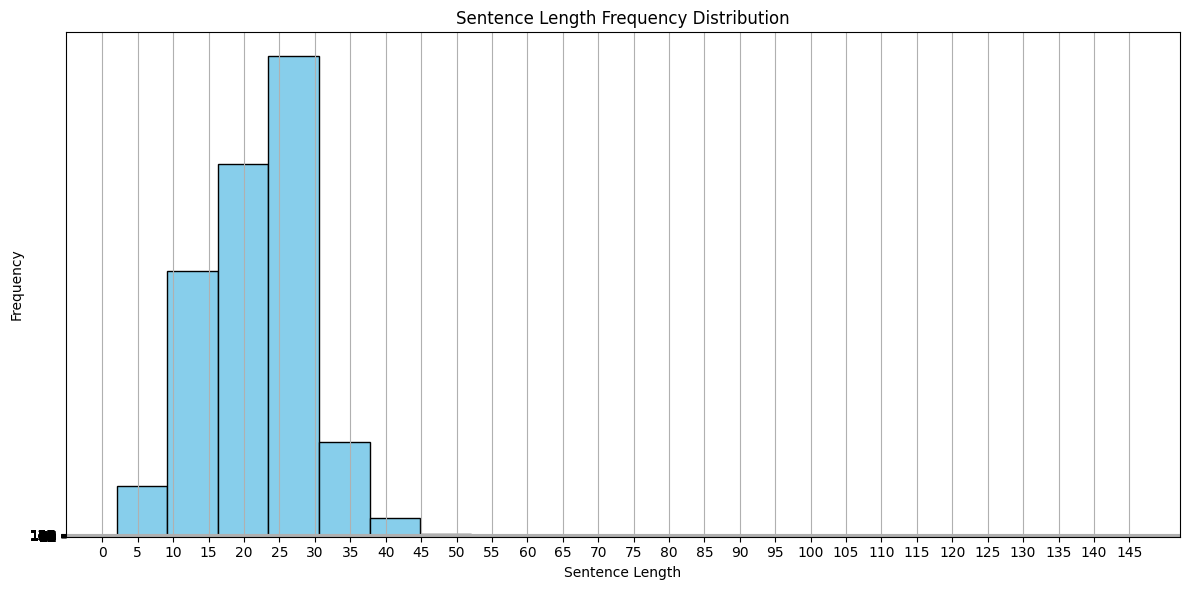

------------------------------------------------------------------------------------------------------------------
Chaos data counts: 71
lgg6好不好？
3d2018122期推荐
美国
No More Nice Girls，然后呢？
Back to business！！！
------------------------------------------------------------------------------------------------------------------
Number of duplicate items: 4310
Sample duplicates (item: count): [('经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？', 3), ('方舟子说象棋源自印度，中国古代没有大象，你认为这种说法怎么样？', 51), ('高考志愿影响了你的未来吗？', 2), ('古希腊众神那点事儿（1）', 3), ('上联：一生二，二生三，三生万物物物生辉。怎么对下联？', 7)]
Total number of news after filter: 74975


In [34]:
# just do a analysis on the data

import re
import matplotlib.pyplot as plt

DEVIDE = "------------------------------------------------------------------------------------------------------------------"

empty_data = [item for item in all_data_np if not item or item.strip()=='']
print("Empty data: %d"%len(empty_data))

print(DEVIDE)

lengths = [len(item) for item in all_data_np]
min_index = np.argmin(lengths)
max_index = np.argmax(lengths)
print(f"min length: {lengths[min_index]}, max length: {lengths[max_index]}, average:{np.mean(lengths): .2f}")

short_data = [item for item in all_data_np if len(item) < 8]
print(f"Short data counts: {len(short_data)}")
print('\n'.join(short_data[0:5]))

plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=20, edgecolor='black', color='skyblue')
plt.title('Sentence Length Frequency Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, max(lengths) + 1, 5))
plt.yticks(range(0, max(lengths) + 1, 1))
plt.tight_layout()
plt.show()

print(DEVIDE)

chinese_pattern = re.compile(r'[\u4e00-\u9fa5]')
chaos_data = [item for item in all_data_np if len(chinese_pattern.findall(item))<4]
print(f"Chaos data counts: {len(chaos_data)}")
print('\n'.join(chaos_data[0:5]))

print(DEVIDE)

from collections import Counter

data_counter = Counter(all_data_np)

duplicates = {item: count for item, count in data_counter.items() if count > 1}
print(f"Number of duplicate items: {len(duplicates)}")
print("Sample duplicates (item: count):", list(duplicates.items())[0:5])

# now filter
filter_data = all_data_np
filter_data = [item for item in filter_data if 8<=len(item)<60]
filter_data = [item for item in filter_data if len(chinese_pattern.findall(item))>=4]
filter_data = list(set(filter_data))
print(f"Total number of news after filter: {len(filter_data)}")

# 3. Get embeddings for the news

We need to convert the news titles into some kind of numerical representation (embedding) before we can do clustering on them. Below are two ways to get embeddings for a paragraph of text:

1. **Pretrained word embeddings**: You can use pretrained word embeddings like Glove to get embeddings for each word in the news, and then average them (or try some more advanced techniques) to get the news embedding.

2. **General text embedding models**: You can use general text embedding models to get embedding for a sentence directly.

You can choose either of them to convert the news titles into embeddings.

In [35]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer

def segment(text):
    return ' '.join(jieba.cut(text))  

segmented_texts = [segment(sentence) for sentence in filter_data]

vectorizer = TfidfVectorizer()
sentence_embeddings = vectorizer.fit_transform(segmented_texts)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\李增昊\AppData\Local\Temp\jieba.cache
Loading model cost 0.952 seconds.
Prefix dict has been built successfully.


# 4. Clustering

Do K-means clustering

In [36]:
clusters = 15
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(sentence_embeddings)

View samples in each cluster

In [37]:
random_sample = True
for i in range(clusters):
    print(f'Cluster {i} has {np.sum(kmeans.labels_ == i)} sentences')
    if random_sample:
        print('\n'.join(all_data_np[np.random.choice(np.where(kmeans.labels_ == i)[0], 5)]))
    else:
        print('\n'.join(all_data_np[kmeans.labels_ == i][0:5]))
    print('')

Cluster 0 has 746 sentences
为什么苹果公司敢在我国这么强势？
孟加拉4万平米晒砖场似火车轨道 紧密排布绵延不绝
传承红大、抗大血脉，让三尺讲台连接未来战场
盛鸣初起，名贯盛京
一样的菜为啥不一样的味道

Cluster 1 has 55351 sentences
完全搜集！黑龙江农垦城镇全揭秘
撞到电瓶车怎么办？千万不要急着负责！
汶川大地震十周年，那些人，今天仍然令人潸然泪下
《死亡笔记》中3大死神介绍合集，有多少还记得帅帅L和夜神月
面对智能手机的竞争，电脑系统还会有下一代吗？

Cluster 2 has 517 sentences
这就是内蒙古
华为轮值董事长郭平现身青岛，牵手袁隆平“袁米”，考察海尔集团
俄罗斯为什么不敢用核武反击西方制裁？
越来越多女人上厕所不用纸擦，只需一个简单的小物，涨见识了
澳前外交官第 8 次回乡，带回新版《哈尔滨档案》

Cluster 3 has 1927 sentences
水银和银哪个密度大？
洛杉矶尔湾的军人公墓需要您的选票！
东方红一号卫星早就失去联系了，为何在太空飞了48年还不收回？
埃及的"白雪公主"，拥有无数璀璨的珠宝，却经历十分不幸的婚姻
房地产降温进行时：房贷利率又涨了！

Cluster 4 has 889 sentences
有哪些寥寥几字可以让人潸然泪下的诗句？
国安2-2富力的比赛中，主裁王迪的两次判罚引起争议，您认为是否合理？
用SPSS做相关分析，通过了显著性检验但相关系数低，该怎么解释？
“人生如月，阴晴圆缺”，如何对下一句？
全国青年教师教学艺术大赛举行

Cluster 5 has 1269 sentences
他们用一生的写作曲折回应原生家庭的深刻记忆
巨头扎堆涌入，智能音箱创业者如何避免成为炮灰？
5月珠海房贷利率最新调查！停贷增多审核趋严
直销及其拉人头的营销模式还有生存的空间吗？
《费恩曼物理学讲义》是否可以用来做非物理专业本科教材？

Cluster 6 has 2957 sentences
人民的饮食之广渠门内平娃三宝，曾经的深夜食堂
用大炮发射卫星，中国即将首次尝试，背后隐含众多黑科技
如果美俄不插手，以色列和伊朗谁的胜算高？
普通家庭如何才能培养出985大学的孩子？农村父母建议看完
蒋欣，出席活动，网友：这发型已经成功抢镜了

Cluster 7 